In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("plotting.mplstyle")
import pandas as pd
import sys
sys.path.append("./../../p-det-O3/")
from p_det_O3.emulator import p_det_O3
import pickle
from scipy.stats import ks_2samp
import jax
from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
np.random.seed(230529)
from figure_utilities import gen_found,make_hist
from astropy.cosmology import Planck15
import astropy.units as u
import matplotlib.patches as mpatches

cbbh = '#1f78b4'
cnsbh = '#33a02c'
cbns = '#e31a1c'
cmisc = '#6a3d9a'

In [2]:
ann = p_det_O3(model_weights="./../data/trained_networks/job_27_weights.hdf5",
                scaler="./../data/trained_networks/job_27_input_scaler.pickle")

jitted_ann = jax.jit(ann)

In [3]:
# BBH params
bbh_found,bbh_nTrials = gen_found(jitted_ann,
                                    10000,
                                    min_m1=2.,
                                    max_m1=100.,
                                    alpha_m1=-2.35,
                                    min_m2=2.,
                                    max_m2=100.,
                                    alpha_m2=1.,
                                    max_a1=0.998,
                                    max_a2=0.998,
                                    zMax=1.9,
                                    kappa=1.,
                                    conditional_mass=True)

In [4]:
def addDerived(data):

    data['amp_factor_a'] = np.log((data.chirp_mass_detector**(5./6.)/data.luminosity_distance*((1.+data.cos_inclination**2)/2))**2)
    data['amp_factor_b'] = np.log((data.chirp_mass_detector**(5./6.)/data.luminosity_distance*data.cos_inclination)**2)
    data['log_m1'] = np.log(data.m1_detector)
    data['log_Mc'] = np.log(data.chirp_mass_detector)
    data['log_Mtot'] = np.log(data.total_mass_detector)
    data['log_d'] = np.log(data.luminosity_distance)
    data['scaled_eta'] = np.log(0.25-data.eta)
    data['sin_declination'] = np.sin(data.declination)
    data['abs_cos_inclination'] = np.abs(data.cos_inclination)
    data['one_plus_z'] = 1.+data.redshift
    data['cos_pol'] = np.cos(data.polarization%np.pi)
    data['sin_pol'] = np.sin(data.polarization%np.pi)
    data['m1_source'] = data.m1_detector/(1.+data.redshift)
    data['Xdiff_PN'] = (data['a1']*data['cost1'] - data['a2']*data['cost2'])/2.

# Load reference training data and extract detections
bbh_reference_data = pd.read_hdf("./../data/training_data/bbh_training_data.hdf")

addDerived(bbh_reference_data)

bbh_reference_found = bbh_reference_data[bbh_reference_data.detected==1]

In [5]:
raw_bbh,raw_bbh_nTrials = gen_found(lambda x: np.ones(x.shape[1]),
                                    100000,
                                    min_m1=2.,
                                    max_m1=100.,
                                    alpha_m1=-2.35,
                                    min_m2=2.,
                                    max_m2=100.,
                                    alpha_m2=1.,
                                    max_a1=0.998,
                                    max_a2=0.998,
                                    zMax=1.9,
                                    kappa=1.,
                                    conditional_mass=True)

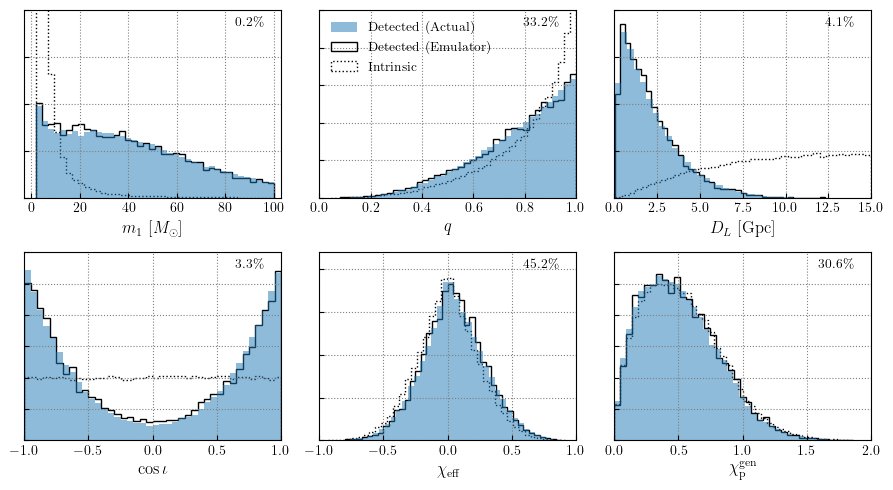

In [6]:
fig = plt.figure(figsize=(9,5))

nBins = 40

ax = fig.add_subplot(231)
make_hist(ax,bbh_reference_found,bbh_found,raw_bbh,'m1_source',color=cbbh,
          ref_bins=nBins,new_bins=nBins,raw_bins=nBins,
          xlim=(-3,103),ylim=(0,0.04),
          label=r"$m_1\,\,[M_\odot]$")

ax = fig.add_subplot(232)
make_hist(ax,bbh_reference_found,bbh_found,raw_bbh,'q',color=cbbh,
         ref_bins=nBins,new_bins=nBins,raw_bins=nBins,
         xlim=(0,1),ylim=(0,5),
         label=r"$q$",
         legend=True)

ax = fig.add_subplot(233)
make_hist(ax,bbh_reference_found,bbh_found,raw_bbh,'luminosity_distance',color=cbbh,
         ref_bins=nBins,new_bins=nBins,raw_bins=nBins,
         xlim=(0,15),ylim=(0,0.4),
         label=r"$D_L\,\,[\mathrm{Gpc}]$")

ax = fig.add_subplot(234)
make_hist(ax,bbh_reference_found,bbh_found,raw_bbh,'cos_inclination',color=cbbh,
         ref_bins=nBins,new_bins=nBins,raw_bins=nBins,
         xlim=(-1,1),ylim=(0,1.5),
         label=r"$\cos\iota$")

ax = fig.add_subplot(235)
make_hist(ax,bbh_reference_found,bbh_found,raw_bbh,'Xeff',color=cbbh,
         ref_bins=nBins,new_bins=nBins,raw_bins=nBins,
         xlim=(-1,1),ylim=(0,2.2),
         label=r"$\chi_\mathrm{eff}$")

ax = fig.add_subplot(236)
make_hist(ax,bbh_reference_found,bbh_found,raw_bbh,'Xp_gen',color=cbbh,
         ref_bins=nBins,new_bins=nBins,raw_bins=nBins,
         xlim=(0,2),ylim=(0,1.5),
         label=r"$\chi_\mathrm{p}^{\rm gen}$")

plt.tight_layout()
plt.savefig('figure_03.pdf',bbox_inches='tight')

In [7]:
semianalytic = np.load('BBH_semianalytic.npy',allow_pickle=True)[()]

def get_reweighted_draws(selection):

    m1_semianalytic = semianalytic[selection]['m1']
    m2_semianalytic = semianalytic[selection]['m2']
    a1_semianalytic = semianalytic[selection]['a1']
    a2_semianalytic = semianalytic[selection]['a2']
    z_semianalytic = semianalytic[selection]['z']
    DL_semianalytic = semianalytic[selection]['DL']
    Xeff_semianalytic = semianalytic[selection]['Xeff']
    Xp_semianalytic = semianalytic[selection]['Xp']
    cos_inc_semianalytic = semianalytic[selection]['cos_inc']
    pdraw = semianalytic[selection]['pdraw']

    alpha1 = -2.35
    p_m1 = m1_semianalytic**alpha1
    p_m1[m1_semianalytic<2] = 0
    p_m1[m1_semianalytic>100] = 0

    alpha2 = 1
    p_m2 = m2_semianalytic**alpha2/(m1_semianalytic**(1.+alpha2)-2.**(1.+alpha2))
    p_m2[m2_semianalytic<2] = 0

    kappa = 1.
    dVdz = Planck15.differential_comoving_volume(z_semianalytic).to(u.Gpc**3/u.sr).value
    p_z = dVdz*(1.+z_semianalytic)**(kappa-1)

    p_a1 = 1.
    p_a2 = 1.
    p_theta1 = 1/2.
    p_theta2 = 1/2.

    p_target = p_m1*p_m2*p_z*p_a1*p_a2*p_theta1*p_theta2
    ws = p_target/pdraw
    ws /= np.sum(ws)

    print(np.sum(ws)**2/np.sum(ws**2))
    
    random_draws = np.random.choice(np.arange(m1_semianalytic.size),10000,p=ws)

    draws = {'m1':m1_semianalytic[random_draws],
             'm2':m2_semianalytic[random_draws],
             'DL':DL_semianalytic[random_draws],
             'z':z_semianalytic[random_draws],
             'Xeff':Xeff_semianalytic[random_draws],
             'Xp':Xp_semianalytic[random_draws],
             'cos_inc':cos_inc_semianalytic[random_draws],
            }
    draws['q'] = draws['m2']/draws['m1']
    
    return draws

198894.52634332888
174870.93085192068


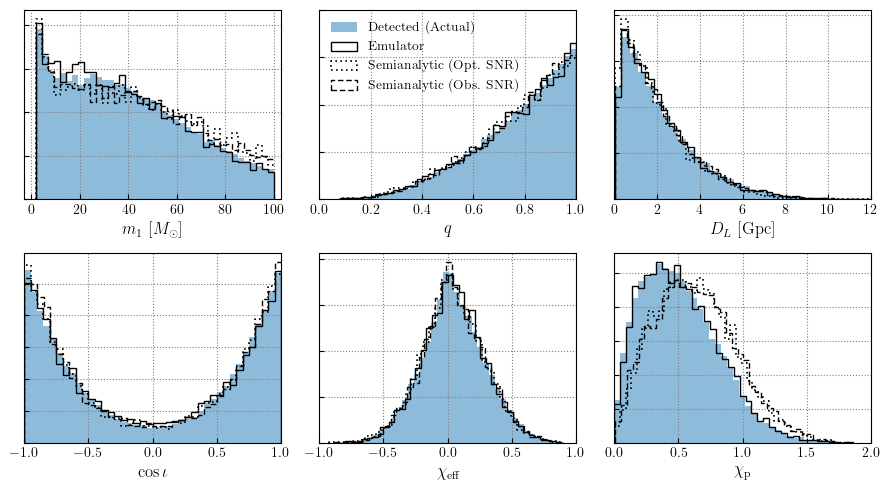

In [115]:
obs_snr_draws = get_reweighted_draws('obs_snr')
expected_snr_draws = get_reweighted_draws('expected_snr')

fig = plt.figure(figsize=(9,5))
nBins = 40

ax = fig.add_subplot(231)
ax.hist(bbh_reference_found['m1_source'].values, density=True, bins=40, color=cbbh, alpha=0.5)
ax.hist(bbh_found['m1_source'].values, density=True, histtype='step', bins=40, color='black')
heights, edges = np.histogram(obs_snr_draws['m1'], density=True, bins=40)
l, = ax.step(edges, np.concatenate([[0],heights]), where='pre', color='black', lw=1.)
l.set_dashes((4,2))
heights, edges = np.histogram(expected_snr_draws['m1'], density=True, bins=40)
l, = ax.step(edges, np.concatenate([[0],heights]), where='pre', color='black', lw=1.2)
l.set_dashes((1,2))
ax.set_xlim(-3,103)
ax.set_yticklabels([])
ax.set_xlabel('$m_1$ [$M_\odot$]')

ax = fig.add_subplot(232)
ax.hist(bbh_reference_found['q'].values, density=True, bins=40, color=cbbh, alpha=0.5)
ax.hist(bbh_found['q'].values, density=True, histtype='step', bins=40, color='black')
heights, edges = np.histogram(obs_snr_draws['q'], density=True, bins=40)
l, = ax.step(edges, np.concatenate([[0],heights]), where='pre', color='black', lw=1.)
l.set_dashes((4,2))
heights, edges = np.histogram(expected_snr_draws['q'], density=True, bins=40)
l, = ax.step(edges, np.concatenate([[0],heights]), where='pre', color='black', lw=1.2)
l.set_dashes((1,2))
ax.set_xlim(0,1)
ax.set_ylim(0,4)
ax.set_yticklabels([])
ax.set_xlabel('$q$')

patch1 = mpatches.Patch(color=cbbh, alpha=0.5, label='Detected (Actual)', lw=0)
patch2 = mpatches.Patch(facecolor='white', edgecolor='black', 
                        label='Emulator')
patch3 = mpatches.Patch(facecolor='white', edgecolor='black',
                        label='Semianalytic (Opt. SNR)', lw=1.2, linestyle=(0, (1, 2)))
patch4 = mpatches.Patch(facecolor='white', edgecolor='black',
                        label='Semianalytic (Obs. SNR)', lw=1, linestyle=(0, (4, 2)))
ax.legend(handles=[patch1, patch2, patch3, patch4], loc='upper left', fontsize=9.5, frameon=False)

ax = fig.add_subplot(233)
ax.hist(bbh_reference_found['luminosity_distance'].values, density=True, bins=40, color=cbbh, alpha=0.5)
ax.hist(bbh_found['luminosity_distance'].values, density=True, histtype='step', bins=40, color='black')
heights, edges = np.histogram(obs_snr_draws['DL'], density=True, bins=40)
l, = ax.step(edges, np.concatenate([[0],heights]), where='pre', color='black', lw=1.)
l.set_dashes((4,2))
heights, edges = np.histogram(expected_snr_draws['DL'], density=True, bins=40)
l, = ax.step(edges, np.concatenate([[0],heights]), where='pre', color='black', lw=1.2)
l.set_dashes((1,2))
ax.set_xlim(0,12)
ax.set_yticklabels([])
ax.set_xlabel('$D_L$ [Gpc]')

ax = fig.add_subplot(234)
ax.hist(bbh_reference_found['cos_inclination'].values, density=True, bins=40, color=cbbh, alpha=0.5)
ax.hist(bbh_found['cos_inclination'].values, density=True, histtype='step', bins=40, color='black')
heights, edges = np.histogram(obs_snr_draws['cos_inc'], density=True, bins=40)
l, = ax.step(edges, np.concatenate([[0],heights]), where='pre', color='black', lw=1.)
l.set_dashes((4,2))
heights, edges = np.histogram(expected_snr_draws['cos_inc'], density=True, bins=40)
l, = ax.step(edges, np.concatenate([[0],heights]), where='pre', color='black', lw=1.2)
l.set_dashes((1,2))
ax.set_xlim(-1,1)
ax.set_yticklabels([])
ax.set_xlabel('$\cos\iota$')

ax = fig.add_subplot(235)
ax.hist(bbh_reference_found['Xeff'].values, density=True, bins=40, color=cbbh, alpha=0.5)
ax.hist(bbh_found['Xeff'].values, density=True, histtype='step', bins=40, color='black')
heights, edges = np.histogram(obs_snr_draws['Xeff'], density=True, bins=40)
l, = ax.step(edges, np.concatenate([[0],heights]), where='pre', color='black', lw=1.)
l.set_dashes((4,2))
heights, edges = np.histogram(expected_snr_draws['Xeff'], density=True, bins=40)
l, = ax.step(edges, np.concatenate([[0],heights]), where='pre', color='black', lw=1.2)
l.set_dashes((1,2))
ax.set_xlim(-1,1)
ax.set_yticklabels([])
ax.set_xlabel('$\chi_\mathrm{eff}$')

ax = fig.add_subplot(236)
ax.hist(bbh_reference_found['Xp_gen'].values, density=True, bins=40, color=cbbh, alpha=0.5)
ax.hist(bbh_found['Xp_gen'].values, density=True, histtype='step', bins=40, color='black')
heights, edges = np.histogram(obs_snr_draws['Xp'], density=True, bins=40)
l, = ax.step(edges, np.concatenate([[0],heights]), where='pre', color='black', lw=1.)
l.set_dashes((4,2))
heights, edges = np.histogram(expected_snr_draws['Xp'], density=True, bins=40)
l, = ax.step(edges, np.concatenate([[0],heights]), where='pre', color='black', lw=1.2)
l.set_dashes((1,2))
ax.set_xlim(0,2)
ax.set_yticklabels([])
ax.set_xlabel('$\chi_\mathrm{p}$')

plt.tight_layout()
plt.savefig('bbh_semianalytic.pdf',bbox_inches='tight')
plt.show()

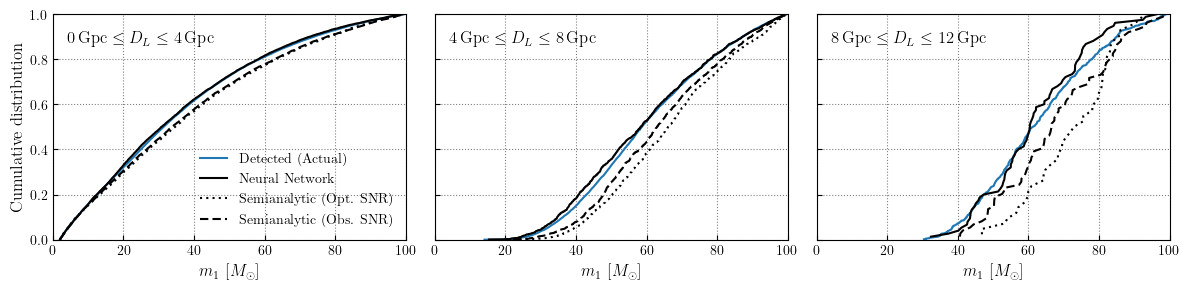

In [116]:
fig = plt.figure(figsize=(12,3))

ax = fig.add_subplot(131)
D_min = 0
D_max = 4

xs = bbh_reference_found['m1_source'].values[(bbh_reference_found['luminosity_distance']>D_min)*(bbh_reference_found['luminosity_distance']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size,
        color=cbbh, label='Detected (Actual)')

xs = bbh_found['m1_source'].values[(bbh_found['luminosity_distance']>D_min)*(bbh_found['luminosity_distance']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size,
        color='black', label='Neural Network')

xs = expected_snr_draws['m1'][(expected_snr_draws['DL']>D_min)*(expected_snr_draws['DL']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size,
        color='black', dashes=(1,2), label='Semianalytic (Opt. SNR)')

xs = obs_snr_draws['m1'][(obs_snr_draws['DL']>D_min)*(obs_snr_draws['DL']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size,
        color='black', dashes=(4,2), label='Semianalytic (Obs. SNR)')

ax.text(0.04, 0.87, r'$0\,\mathrm{Gpc} \leq D_L \leq 4\,\mathrm{Gpc}$',
        transform=ax.transAxes, fontsize=12)
ax.set_xlim(0,100)
ax.set_ylim(0,1)
ax.set_xlabel(r'$m_1$ [$M_\odot$]')
ax.set_ylabel(r'Cumulative distribution')
ax.legend(loc='lower right')

ax = fig.add_subplot(132)
D_min = 4
D_max = 8

xs = bbh_reference_found['m1_source'].values[(bbh_reference_found['luminosity_distance']>D_min)*(bbh_reference_found['luminosity_distance']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size, color=cbbh)

xs = bbh_found['m1_source'].values[(bbh_found['luminosity_distance']>D_min)*(bbh_found['luminosity_distance']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size, color='black')

xs = obs_snr_draws['m1'][(obs_snr_draws['DL']>D_min)*(obs_snr_draws['DL']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size, color='black', dashes=(4,2))

xs = expected_snr_draws['m1'][(expected_snr_draws['DL']>D_min)*(expected_snr_draws['DL']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size, color='black', dashes=(1,2))

ax.text(0.04, 0.87, r'$4\,\mathrm{Gpc} \leq D_L \leq 8\,\mathrm{Gpc}$',
        transform=ax.transAxes, fontsize=12)
ax.set_xlim(0,100)
ax.set_ylim(0,1)
ax.set_yticklabels([])
ax.set_xlabel(r'$m_1$ [$M_\odot$]')

ax = fig.add_subplot(133)
D_min = 8
D_max = 12

xs = bbh_reference_found['m1_source'].values[(bbh_reference_found['luminosity_distance']>D_min)*(bbh_reference_found['luminosity_distance']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size, color=cbbh)

xs = bbh_found['m1_source'].values[(bbh_found['luminosity_distance']>D_min)*(bbh_found['luminosity_distance']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size, color='black')

xs = obs_snr_draws['m1'][(obs_snr_draws['DL']>D_min)*(obs_snr_draws['DL']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size, color='black', dashes=(4,2))

xs = expected_snr_draws['m1'][(expected_snr_draws['DL']>D_min)*(expected_snr_draws['DL']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size, color='black', dashes=(1,2))

ax.text(0.04, 0.87, r'$8\,\mathrm{Gpc} \leq D_L \leq 12\,\mathrm{Gpc}$',
        transform=ax.transAxes, fontsize=12)
ax.set_xlim(0,100)
ax.set_ylim(0,1)
ax.set_yticklabels([])
ax.set_xlabel(r'$m_1$ [$M_\odot$]')

plt.savefig('dist-dependent-masses.pdf',bbox_inches='tight')
plt.tight_layout()

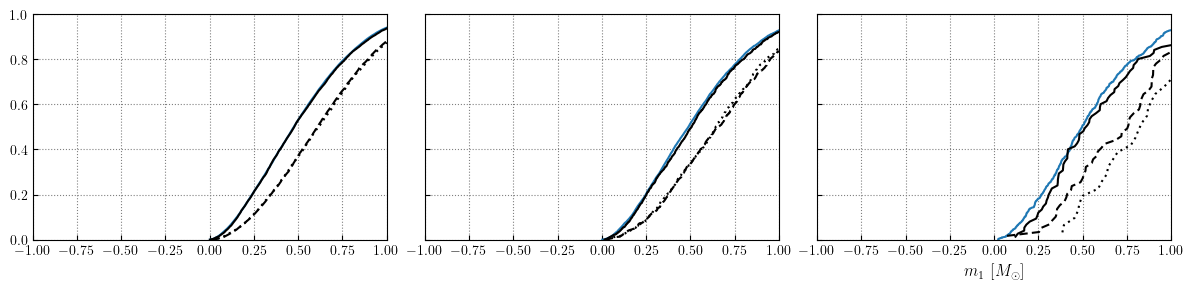

In [100]:
fig = plt.figure(figsize=(12,3))

ax = fig.add_subplot(131)
D_min = 0
D_max = 4

xs = bbh_reference_found['Xp_gen'].values[(bbh_reference_found['luminosity_distance']>D_min)*(bbh_reference_found['luminosity_distance']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size, color=cbbh)

xs = bbh_found['Xp_gen'].values[(bbh_found['luminosity_distance']>D_min)*(bbh_found['luminosity_distance']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size, color='black')

xs = obs_snr_draws['Xp'][(obs_snr_draws['DL']>D_min)*(obs_snr_draws['DL']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size, color='black', dashes=(4,2))

xs = expected_snr_draws['Xp'][(expected_snr_draws['DL']>D_min)*(expected_snr_draws['DL']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size, color='black', dashes=(1,2))

ax.set_xlim(-1,1)
ax.set_ylim(0,1)

ax = fig.add_subplot(132)
D_min = 4
D_max = 8

xs = bbh_reference_found['Xp_gen'].values[(bbh_reference_found['luminosity_distance']>D_min)*(bbh_reference_found['luminosity_distance']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size, color=cbbh)

xs = bbh_found['Xp_gen'].values[(bbh_found['luminosity_distance']>D_min)*(bbh_found['luminosity_distance']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size, color='black')

xs = obs_snr_draws['Xp'][(obs_snr_draws['DL']>D_min)*(obs_snr_draws['DL']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size, color='black', dashes=(4,2))

xs = expected_snr_draws['Xp'][(expected_snr_draws['DL']>D_min)*(expected_snr_draws['DL']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size, color='black', dashes=(1,2))

ax.set_xlim(-1,1)
ax.set_ylim(0,1)
ax.set_yticklabels([])

ax = fig.add_subplot(133)
D_min = 8
D_max = 12

xs = bbh_reference_found['Xp_gen'].values[(bbh_reference_found['luminosity_distance']>D_min)*(bbh_reference_found['luminosity_distance']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size, color=cbbh)

xs = bbh_found['Xp_gen'].values[(bbh_found['luminosity_distance']>D_min)*(bbh_found['luminosity_distance']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size, color='black')

xs = obs_snr_draws['Xp'][(obs_snr_draws['DL']>D_min)*(obs_snr_draws['DL']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size, color='black', dashes=(4,2))

xs = expected_snr_draws['Xp'][(expected_snr_draws['DL']>D_min)*(expected_snr_draws['DL']<D_max)]
ax.plot(np.sort(xs),np.cumsum(np.ones_like(xs))/xs.size, color='black', dashes=(1,2))

ax.set_xlim(-1,1)
ax.set_ylim(0,1)
ax.set_yticklabels([])
ax.set_xlabel(r'$m_1$ [$M_\odot$]')

plt.tight_layout()